### CryoParticleSegment

In [ ]:
#%%bash
#git clone git+https://cyanazuki@github.com/cyanazuki/CryoParticleSegment.git
#cd CryoParticleSegment
#python setup.py install

In [1]:
%pip install torchinfo -qq
%pip install -U git+https://github.com/qubvel/segmentation_models.pytorch -qq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 32.7 MB/s eta 0:00:00


In [2]:
%pip install mrcfile -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


## ⭐ Setup
You must run all codes under this category.

### ✅ Directory Settings

In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [12]:
# @title  { display-mode: "form" }

IMAGE_DIR = "/content/drive/MyDrive/research_xs/dataset/10081/processed_micrographs_np_split" # @param {type:"string"}
LABEL_DIR = "/content/drive/MyDrive/research_xs/dataset/10081/micrographs_ground_np" # @param {type:"string"}
RESULT_DIR = "/content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice" # @param {type:"string"}

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# @title  { display-mode: "form" }
# @markdown Detect whether using folder in Google Drive as **`RESULT DIR`**📁.

if "content" in IMAGE_DIR.split("/")[:3] or "content" in LABEL_DIR.split("/")[:3]:
  try:
    from google.colab import drive
    drive.mount('/content/drive')
    !rm -r /content/sample_data
    if "content" in IMAGE_DIR.split("/")[:3]:
      !cp -r {IMAGE_DIR} /content/image_dir # Do not need test
      IMAGE_DIR = "/content/image_dir"
    if "content" in LABEL_DIR.split("/")[:3]:
      !cp -r {LABEL_DIR} /content/label_dir
      LABEL_DIR = "/content/label_dir"
  except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
IMAGE_DIR = "/content/image_dir"

In [9]:
# @title  { display-mode: "form" }
# @markdown Source code directory.
SRC_DIR = "/content/drive/MyDrive/00_Image\ meeting/Researches/01_Scratchpad/seg_src/CryoParticleSegment-main/Modeling" # @param {type:"string"}

if True:
  !cp -rf {SRC_DIR}/* /content/
else:
  !cp {SRC_DIR}/convcrf.py /content/convcrf.py
  !cp {SRC_DIR}/dataset.py /content/dataset.py
  !cp {SRC_DIR}/lr_scheduler.py /content/lr_scheduler.py
  !cp {SRC_DIR}/metrics.py /content/metrics.py
  !cp {SRC_DIR}/model.py /content/model.py
  !cp {SRC_DIR}/trainer.py /content/trainer.py
  !cp {SRC_DIR}/utils.py /content/utils.py

### ✅ Packages Handling

In [10]:
# @title  { display-mode: "form" }
# @markdown Useful packages.

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [11]:
# @title  { display-mode: "form" }
# @markdown User-defined packages.

from dataset import MicrographDataset, MicrographDatasetEvery
from dataset import reconstruct_patched
from model import create_model
from trainer import CryoEMEvaluator
from trainer import CryoEMTrainerWithScheduler, tqdm_plugin_for_Trainer

## ⭐ Main

### ✅ Setting

In [16]:
# @markdown Parameters.

NUM_CLASSES = 2
EPOCHS = 50
BATCH = 2
CROP_SIZE = (512, 512)
LR = 1e-3
RLR_PATIENCE = 3
ES_PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# @markdown Set seed.

random_state = 42
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### ✅ Dataset

In [17]:
train_dir = os.path.join(IMAGE_DIR, 'train')
train_filenames = np.loadtxt(f"{IMAGE_DIR}/train_filenames.txt", dtype=str)
train_dataset = MicrographDataset(image_dir=train_dir, label_dir=LABEL_DIR, filenames=train_filenames, crop_size=CROP_SIZE, num_patches = 4, crop=None)

In [18]:
val_dir = os.path.join(IMAGE_DIR, 'val')
val_filenames = np.loadtxt(f"{IMAGE_DIR}/val_filenames.txt", dtype=str)
val_dataset = MicrographDatasetEvery(image_dir=val_dir, label_dir=LABEL_DIR, filenames=val_filenames, crop_size=CROP_SIZE, crop=None)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=False, pin_memory=True)

In [19]:
test_dir = os.path.join(IMAGE_DIR, 'test')
test_filenames = np.loadtxt(f"{IMAGE_DIR}/test_filenames.txt", dtype=str)
test_dataset = MicrographDatasetEvery(image_dir=test_dir, label_dir=LABEL_DIR, filenames=test_filenames, crop_size=CROP_SIZE)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False, pin_memory=True)

In [20]:
for i1, i2, i3, i4 in val_loader: #test loader and reconstruct
    print(i2.dtype, i4.dtype)
    print(i2.shape, i4.shape)
    break

torch.int64 torch.int64
torch.Size([81, 1, 512, 512]) torch.Size([1, 3838, 3710])


## ⭐ Convcrf wtih FCN finetuned on cryoem

## The model

### ✅ Model

In [21]:
# @title  { display-mode: "form" }

architecture = "Unet++" # @param {type:"string"}
encoder = "timm-efficientnet-b5" # @param {type:"string"}
pretrained = True # @param {type:"boolean"}
loss = "dice" # @param {type:"string"}

In [22]:
import segmentation_models_pytorch as smp

if pretrained:
  weights = "imagenet"
else:
  weights = None

if architecture == "Unet++":
    backbone = smp.UnetPlusPlus(
        encoder_name=encoder,        # choose encoder, densenet201, resnet50, e.g. mobilenet_v2 or efficientnet-b5
        encoder_weights=weights,     # use `imagenet` or `advprop` for pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset)
    )

elif architecture == "Deeplab":
    backbone = smp.DeepLabV3(
        encoder_name=encoder,        # choose encoder, densenet201, resnet50, e.g. mobilenet_v2 or efficientnet-b5
        encoder_weights=weights,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset)
    )
else:
    print("Architecture not supported")
    raise NotImplementedError

model = create_model(backbone, addout=True) #crf_args

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5-c6949ce9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5-c6949ce9.pth
100%|██████████| 117M/117M [00:02<00:00, 46.6MB/s]


In [23]:
print(model)

Model_Out(
  (backbone): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
    

In [24]:
from torchinfo import summary
summary(model, input_size=(BATCH, 1, 512, 512))

Layer (type:depth-idx)                                  Output Shape              Param #
Model_Out                                               [2, 2, 512, 512]          --
├─UnetPlusPlus: 1-1                                     [2, 2, 512, 512]          --
│    └─EfficientNetEncoder: 2-1                         [2, 1, 512, 512]          1,052,672
│    │    └─Conv2d: 3-1                                 [2, 48, 256, 256]         432
│    │    └─BatchNormAct2d: 3-2                         [2, 48, 256, 256]         96
│    │    └─Sequential: 3-3                             --                        27,286,720
│    └─UnetPlusPlusDecoder: 2-2                         [2, 16, 512, 512]         --
│    │    └─ModuleDict: 3-4                             --                        3,569,152
│    └─SegmentationHead: 2-3                            [2, 2, 512, 512]          --
│    │    └─Conv2d: 3-5                                 [2, 2, 512, 512]          290
│    │    └─Identity: 3-6           

In [25]:
import math
if loss == "dice":
    criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
elif loss == "cross_entropy":
    criterion = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.1)
elif loss == "jaccard":
    criterion = smp.losses.JaccardLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
elif loss == "Lovasz":
    criterion = smp.losses.LovaszLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
elif loss == "Tversky":
    criterion = smp.losses.TverskyLoss(smp.losses.MULTICLASS_MODE, from_logits=True, alpha=0.45, beta=0.55, gamma=2, smooth=0.1)
else:
    print("Loss not supported")
    raise NotImplementedError
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#scheduler = ReduceLROnPlateau(optimizer, patience=RLR_PATIENCE, verbose=True)
scheduler = OneCycleLR(optimizer, max_lr=LR, verbose=True, steps_per_epoch=math.ceil(len(train_dataset)/BATCH), epochs=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
!mkdir -p {RESULT_DIR}

### ✅ Training

In [28]:
# Unet++ eb5 Dice denoise2
Trainer = tqdm_plugin_for_Trainer(CryoEMTrainerWithScheduler)
trainer = Trainer(model, train_dataset, criterion, optimizer, DEVICE,
              num_classes = NUM_CLASSES,
              lr_scheduler=scheduler, patience=ES_PATIENCE)

trainer.train(EPOCHS, val_loader=val_loader, batch_size = BATCH,
              ckpt_dir = RESULT_DIR, random_state = random_state)

Epoch   1/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 5.0665522117580375e-05
Training score:
  loss	: 0.6019


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.6810
Iou by Class: [0.1845462  0.10523636]
Precision by Class: [0.8981813  0.10770881]
Recall by Class: [0.18848948 0.8209317 ]
Accuracy by Class: [0.25591066 0.25591066]
F1_score by Class: [0.31158972 0.19043231]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint1.pt
Loss improve to 0.6809541881084442.
Epoch   2/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 8.218811612848581e-05
Training score:
  loss	: 0.5890


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.6259
Iou by Class: [0.32587555 0.11181827]
Precision by Class: [0.91369164 0.11654499]
Recall by Class: [0.33622545 0.7338343 ]
Accuracy by Class: [0.37861234 0.37861234]
F1_score by Class: [0.49156275 0.20114486]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint2.pt
Loss improve to 0.6258661647637686.
Epoch   3/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0001331669281842712
Training score:
  loss	: 0.5675


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.6277
Iou by Class: [0.3278496  0.12691659]
Precision by Class: [0.9443695  0.13018237]
Recall by Class: [0.334306   0.83496225]
Accuracy by Class: [0.38767818 0.38767818]
F1_score by Class: [0.49380532 0.22524573]
No improvement for 1 epoch.
Epoch   4/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00020133647642031594
Training score:
  loss	: 0.5385


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.6435
Iou by Class: [0.31537962 0.14587682]
Precision by Class: [0.9932532  0.14626774]
Recall by Class: [0.3160567 0.9820084]
Accuracy by Class: [0.38705015 0.38705015]
F1_score by Class: [0.47952637 0.25461167]
No improvement for 2 epoch.
Epoch   5/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0002836673282347158
Training score:
  loss	: 0.4626


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.5379
Iou by Class: [0.5474456 0.205505 ]
Precision by Class: [0.9963143  0.20623824]
Recall by Class: [0.54855657 0.9829935 ]
Accuracy by Class: [0.5948695 0.5948695]
F1_score by Class: [0.7075475  0.34094423]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint5.pt
Loss improve to 0.537929505109787.
Epoch   6/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0003765007272900303
Training score:
  loss	: 0.3821


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.4381
Iou by Class: [0.69909126 0.27941123]
Precision by Class: [0.9966293  0.28100225]
Recall by Class: [0.7007481  0.98013854]
Accuracy by Class: [0.7305324 0.7305324]
F1_score by Class: [0.8229002  0.43678096]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint6.pt
Loss improve to 0.4380733569463094.
Epoch   7/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00047571118745761505
Training score:
  loss	: 0.3466


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.3560
Iou by Class: [0.79657644 0.35696387]
Precision by Class: [0.9928732 0.3635345]
Recall by Class: [0.8011574  0.95180637]
Accuracy by Class: [0.81721723 0.81721723]
F1_score by Class: [0.88677156 0.5261214 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint7.pt
Loss improve to 0.3559500277042389.
Epoch   8/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0005768898280824172
Training score:
  loss	: 0.2897


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.3050
Iou by Class: [0.8343081  0.39938015]
Precision by Class: [0.9902983  0.41157445]
Recall by Class: [0.8411836  0.93093765]
Accuracy by Class: [0.85075176 0.85075176]
F1_score by Class: [0.90967065 0.57079583]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint8.pt
Loss improve to 0.30497323473294574.
Epoch   9/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0006755403032085596
Training score:
  loss	: 0.2367


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.3174
Iou by Class: [0.81022143 0.3695578 ]
Precision by Class: [0.99117017 0.3786366 ]
Recall by Class: [0.81611204 0.93907124]
Accuracy by Class: [0.82922 0.82922]
F1_score by Class: [0.8951628  0.53967464]
No improvement for 1 epoch.
Epoch  10/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0007672786177345102
Training score:
  loss	: 0.2253


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.3153
Iou by Class: [0.80618    0.35942963]
Precision by Class: [0.98842096 0.3710098 ]
Recall by Class: [0.8138663  0.92009944]
Accuracy by Class: [0.8251912 0.8251912]
F1_score by Class: [0.89269066 0.52879477]
No improvement for 2 epoch.
Epoch  11/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0008480279507327434
Training score:
  loss	: 0.2085


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.3108
Iou by Class: [0.80302024 0.35966134]
Precision by Class: [0.9904281  0.36896986]
Recall by Class: [0.8093011  0.93445283]
Accuracy by Class: [0.8226428 0.8226428]
F1_score by Class: [0.89075017 0.52904546]
No improvement for 3 epoch.
Epoch  12/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009141998280487905
Training score:
  loss	: 0.2260


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.3018
Iou by Class: [0.89984286 0.31470785]
Precision by Class: [0.9321364 0.5703788]
Recall by Class: [0.9629266  0.41248518]
Accuracy by Class: [0.90424705 0.90424705]
F1_score by Class: [0.94728136 0.47874945]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint12.pt
Loss improve to 0.30177125334739685.
Epoch  13/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009628535929281678
Training score:
  loss	: 0.2158


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2292
Iou by Class: [0.8990522 0.4548242]
Precision by Class: [0.96628964 0.54757655]
Recall by Class: [0.9281637  0.72863835]
Accuracy by Class: [0.90689343 0.90689343]
F1_score by Class: [0.9468431  0.62526345]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint13.pt
Loss improve to 0.22916612029075623.
Epoch  14/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.000991827087848273
Training score:
  loss	: 0.2098


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1995
Iou by Class: [0.91964585 0.50911   ]
Precision by Class: [0.96621966 0.6335517 ]
Recall by Class: [0.9501966 0.7216002]
Accuracy by Class: [0.9258272 0.9258272]
F1_score by Class: [0.95814115 0.6747155 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint14.pt
Loss improve to 0.19947485129038492.
Epoch  15/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009999685285032368
Training score:
  loss	: 0.1877


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1976
Iou by Class: [0.9074539 0.5108923]
Precision by Class: [0.9781808  0.57209325]
Recall by Class: [0.92620176 0.8268611 ]
Accuracy by Class: [0.91561145 0.91561145]
F1_score by Class: [0.9514819  0.67627895]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint15.pt
Loss improve to 0.19755175709724426.
Epoch  16/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.000997452947462627
Training score:
  loss	: 0.1715


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2501
Iou by Class: [0.8506564 0.4294662]
Precision by Class: [0.9927977  0.43983546]
Recall by Class: [0.8559385  0.94796205]
Accuracy by Class: [0.8657485 0.8657485]
F1_score by Class: [0.91930234 0.60087633]
No improvement for 1 epoch.
Epoch  17/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.000990932183889469
Training score:
  loss	: 0.1793


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1971
Iou by Class: [0.92127794 0.5058498 ]
Precision by Class: [0.96379346 0.6462456 ]
Recall by Class: [0.95430595 0.6995589 ]
Accuracy by Class: [0.9271487 0.9271487]
F1_score by Class: [0.9590262 0.6718463]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint17.pt
Loss improve to 0.19708375136057535.
Epoch  18/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.000980458739137906
Training score:
  loss	: 0.1777


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2309
Iou by Class: [0.88805467 0.4437012 ]
Precision by Class: [0.9706677 0.511977 ]
Recall by Class: [0.91254354 0.7689017 ]
Accuracy by Class: [0.89723057 0.89723057]
F1_score by Class: [0.94070864 0.61467177]
No improvement for 1 epoch.
Epoch  19/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009661169392267922
Training score:
  loss	: 0.1802


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2565
Iou by Class: [0.8932161 0.3877365]
Precision by Class: [0.9508316 0.5274125]
Recall by Class: [0.9364708 0.5941693]
Accuracy by Class: [0.8999798 0.8999798]
F1_score by Class: [0.94359654 0.5588042 ]
No improvement for 2 epoch.
Epoch  20/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009480222558961707
Training score:
  loss	: 0.1728


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2152
Iou by Class: [0.8823323  0.48046216]
Precision by Class: [0.9894728 0.5012373]
Recall by Class: [0.89069355 0.9205847 ]
Accuracy by Class: [0.89387995 0.89387995]
F1_score by Class: [0.9374884 0.6490705]
No improvement for 3 epoch.
Epoch  21/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009263203768967173
Training score:
  loss	: 0.1692


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1888
Iou by Class: [0.9200597  0.52431506]
Precision by Class: [0.97058374 0.62862223]
Recall by Class: [0.94645154 0.7596073 ]
Accuracy by Class: [0.9265331 0.9265331]
F1_score by Class: [0.95836574 0.6879353 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint21.pt
Loss improve to 0.18876391152540842.
Epoch  22/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0009011860329976379
Training score:
  loss	: 0.1591


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1919
Iou by Class: [0.924013   0.50390375]
Precision by Class: [0.96084946 0.66813284]
Recall by Class: [0.9601628  0.67213446]
Accuracy by Class: [0.9294576 0.9294576]
F1_score by Class: [0.960506  0.6701277]
No improvement for 1 epoch.
Epoch  23/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0008728215911572529
Training score:
  loss	: 0.1753


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2059
Iou by Class: [0.8913846  0.49469376]
Precision by Class: [0.987147   0.52292895]
Recall by Class: [0.90185165 0.9015938 ]
Accuracy by Class: [0.9018242 0.9018242]
F1_score by Class: [0.9425736  0.66193324]
No improvement for 2 epoch.
Epoch  24/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0008414554251832394
Training score:
  loss	: 0.1695


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1881
Iou by Class: [0.9147671 0.5227254]
Precision by Class: [0.975259  0.6007975]
Recall by Class: [0.93649983 0.8008996 ]
Accuracy by Class: [0.9220442 0.9220442]
F1_score by Class: [0.95548654 0.6865656 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint24.pt
Loss improve to 0.18814252813657126.
Epoch  25/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.000807340077001013
Training score:
  loss	: 0.1952


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2060
Iou by Class: [0.8951824  0.49190181]
Precision by Class: [0.9824988 0.5331095]
Recall by Class: [0.9096882  0.86420053]
Accuracy by Class: [0.904839 0.904839]
F1_score by Class: [0.94469255 0.6594292 ]
No improvement for 1 epoch.
Epoch  26/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0007707502233346375
Training score:
  loss	: 0.1668


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1892
Iou by Class: [0.91450053 0.51547813]
Precision by Class: [0.9730386 0.6019111]
Recall by Class: [0.938276   0.78212273]
Accuracy by Class: [0.9216293 0.9216293]
F1_score by Class: [0.9553411 0.6802845]
No improvement for 2 epoch.
Epoch  27/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0007319804641713486
Training score:
  loss	: 0.1791


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.2085
Iou by Class: [0.91990525 0.46727908]
Precision by Class: [0.95451224 0.6596036 ]
Recall by Class: [0.9620815  0.61576855]
Accuracy by Class: [0.925163 0.925163]
F1_score by Class: [0.95828193 0.6369328 ]
No improvement for 3 epoch.
Epoch  28/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0006913429508156802
Training score:
  loss	: 0.1756


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1843
Iou by Class: [0.9206833  0.52799094]
Precision by Class: [0.97116214 0.6305817 ]
Recall by Class: [0.9465613  0.76444745]
Accuracy by Class: [0.92714715 0.92714715]
F1_score by Class: [0.9587039 0.6910917]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint28.pt
Loss improve to 0.18426917493343353.
Epoch  29/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0006491648726307008
Training score:
  loss	: 0.1526


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1802
Iou by Class: [0.9224115 0.5351318]
Precision by Class: [0.97175556 0.63754165]
Recall by Class: [0.9478229  0.76912814]
Accuracy by Class: [0.9287733 0.9287733]
F1_score by Class: [0.95964   0.6971803]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint29.pt
Loss improve to 0.18015234669049582.
Epoch  30/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.000605785822701648
Training score:
  loss	: 0.1415


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1875
Iou by Class: [0.91929686 0.51348615]
Precision by Class: [0.96788025 0.6292044 ]
Recall by Class: [0.9482248 0.7362883]
Accuracy by Class: [0.9256314 0.9256314]
F1_score by Class: [0.9579517 0.6785475]
No improvement for 1 epoch.
Epoch  31/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0005615550636320821
Training score:
  loss	: 0.1991


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1776
Iou by Class: [0.92121285 0.539517  ]
Precision by Class: [0.9744692 0.628122 ]
Recall by Class: [0.9439967  0.79273075]
Accuracy by Class: [0.92787105 0.92787105]
F1_score by Class: [0.95899093 0.70089126]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint31.pt
Loss improve to 0.17757879197597504.
Epoch  32/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0005168287154867657
Training score:
  loss	: 0.1567


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1764
Iou by Class: [0.92335236 0.54280597]
Precision by Class: [0.9733253  0.63930404]
Recall by Class: [0.94732463 0.78242487]
Accuracy by Class: [0.92974555 0.92974555]
F1_score by Class: [0.96014893 0.7036607 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint32.pt
Loss improve to 0.17639826238155365.
Epoch  33/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00047196688852229853
Training score:
  loss	: 0.1420


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1768
Iou by Class: [0.9236002 0.5410187]
Precision by Class: [0.97246695 0.64185125]
Recall by Class: [0.94840044 0.7749707 ]
Accuracy by Class: [0.92991203 0.92991203]
F1_score by Class: [0.9602829  0.70215726]
No improvement for 1 epoch.
Epoch  34/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00042733078379107134
Training score:
  loss	: 0.1454


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1828
Iou by Class: [0.92406034 0.52142996]
Precision by Class: [0.96583796 0.65669304]
Recall by Class: [0.9552832 0.7168347]
Accuracy by Class: [0.9298635 0.9298635]
F1_score by Class: [0.9605316 0.6854472]
No improvement for 2 epoch.
Epoch  35/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00038327978496277516
Training score:
  loss	: 0.1447


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1813
Iou by Class: [0.92497116 0.52550805]
Precision by Class: [0.9661905 0.6607621]
Recall by Class: [0.95591134 0.7196749 ]
Accuracy by Class: [0.9307274 0.9307274]
F1_score by Class: [0.9610234 0.6889613]
No improvement for 3 epoch.
Epoch  36/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00034016856477840754
Training score:
  loss	: 0.1328


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1799
Iou by Class: [0.9247763  0.53074783]
Precision by Class: [0.96797794 0.65592515]
Recall by Class: [0.95396066 0.73552686]
Accuracy by Class: [0.9306746 0.9306746]
F1_score by Class: [0.9609182 0.6934491]
No improvement for 4 epoch.
Epoch  37/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0002983442294339063
Training score:
  loss	: 0.1388


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1755
Iou by Class: [0.9244774  0.54264534]
Precision by Class: [0.9720825  0.64661103]
Recall by Class: [0.9496922 0.7714266]
Accuracy by Class: [0.9306882 0.9306882]
F1_score by Class: [0.9607569  0.70352566]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint37.pt
Loss improve to 0.17552275955677032.
Epoch  38/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.0002581435238851543
Training score:
  loss	: 0.1396


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1749
Iou by Class: [0.9230715 0.5453581]
Precision by Class: [0.9744904 0.6362122]
Recall by Class: [0.9459285 0.7924841]
Accuracy by Class: [0.9295706 0.9295706]
F1_score by Class: [0.95999706 0.7058016 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint38.pt
Loss improve to 0.1748500814040502.
Epoch  39/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00021989012057559813
Training score:
  loss	: 0.1480


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1744
Iou by Class: [0.9222383 0.5476229]
Precision by Class: [0.97617805 0.6301221 ]
Recall by Class: [0.9434717 0.8070503]
Accuracy by Class: [0.9289285 0.9289285]
F1_score by Class: [0.9595463  0.70769554]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint39.pt
Loss improve to 0.174406960606575.
Epoch  40/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00018389201341604928
Training score:
  loss	: 0.1282


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1753
Iou by Class: [0.92536634 0.542463  ]
Precision by Class: [0.97108805 0.6527033 ]
Recall by Class: [0.9515832 0.7625707]
Accuracy by Class: [0.93143356 0.93143356]
F1_score by Class: [0.9612367 0.7033725]
No improvement for 1 epoch.
Epoch  41/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00015043903799881234
Training score:
  loss	: 0.1639


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1734
Iou by Class: [0.923338   0.54807204]
Precision by Class: [0.97513485 0.63640183]
Recall by Class: [0.94560164 0.7979296 ]
Accuracy by Class: [0.92985904 0.92985904]
F1_score by Class: [0.9601411  0.70807046]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint41.pt
Loss improve to 0.17337639133135477.
Epoch  42/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 0.00011980053801191572
Training score:
  loss	: 0.1427


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1727
Iou by Class: [0.9239011 0.5495396]
Precision by Class: [0.97502625 0.639058  ]
Recall by Class: [0.94629455 0.79687506]
Accuracy by Class: [0.9303657 0.9303657]
F1_score by Class: [0.9604456 0.709294 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint42.pt
Loss improve to 0.17266936103502908.
Epoch  43/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 9.222319664210783e-05
Training score:
  loss	: 0.1469


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1721
Iou by Class: [0.9238083  0.55183154]
Precision by Class: [0.97592384 0.63726026]
Recall by Class: [0.94535345 0.8045507 ]
Accuracy by Class: [0.93034315 0.93034315]
F1_score by Class: [0.96039534 0.7112003 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint43.pt
Loss improve to 0.17209536830584207.
Epoch  44/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 6.792905042688418e-05
Training score:
  loss	: 0.1260


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1729
Iou by Class: [0.92405725 0.5487957 ]
Precision by Class: [0.97459984 0.6404323 ]
Recall by Class: [0.94686043 0.7931935 ]
Accuracy by Class: [0.9304788 0.9304788]
F1_score by Class: [0.96052986 0.70867413]
No improvement for 1 epoch.
Epoch  45/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 4.711370154684303e-05
Training score:
  loss	: 0.1439


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1729
Iou by Class: [0.92234033 0.5503946 ]
Precision by Class: [0.97704434 0.6293525 ]
Recall by Class: [0.9427705 0.8143696]
Accuracy by Class: [0.9290823 0.9290823]
F1_score by Class: [0.95960146 0.7100058 ]
No improvement for 2 epoch.
Epoch  46/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 2.9944742951939617e-05
Training score:
  loss	: 0.1360


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1726
Iou by Class: [0.9238487 0.5495802]
Precision by Class: [0.97509754 0.63871396]
Recall by Class: [0.9461724 0.7974962]
Accuracy by Class: [0.9303228 0.9303228]
F1_score by Class: [0.96041715 0.70932794]
No improvement for 3 epoch.
Epoch  47/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 1.65604090015959e-05
Training score:
  loss	: 0.1332


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1726
Iou by Class: [0.9229134 0.5503114]
Precision by Class: [0.9763812 0.6327138]
Recall by Class: [0.9439883  0.80863005]
Accuracy by Class: [0.92955846 0.92955846]
F1_score by Class: [0.9599115 0.7099366]
No improvement for 4 epoch.
Epoch  48/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 7.068462482919093e-06
Training score:
  loss	: 0.1474


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1715
Iou by Class: [0.92430425 0.5517948 ]
Precision by Class: [0.9753618 0.6403183]
Recall by Class: [0.94640124 0.7996516 ]
Accuracy by Class: [0.93075705 0.93075705]
F1_score by Class: [0.9606633 0.7111698]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint48.pt
Loss improve to 0.17151289184888205.
Epoch  49/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 1.5453269681034844e-06
Training score:
  loss	: 0.1368


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1712
Iou by Class: [0.9244212 0.5529363]
Precision by Class: [0.9756284  0.64041454]
Recall by Class: [0.94627297 0.8019002 ]
Accuracy by Class: [0.93088216 0.93088216]
F1_score by Class: [0.96072644 0.71211714]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint49.pt
Loss improve to 0.17118707795937857.
Epoch  50/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.5471496763224106e-08
Training score:
  loss	: 0.1327


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1716
Iou by Class: [0.92343193 0.5525324 ]
Precision by Class: [0.97658825 0.634637  ]
Recall by Class: [0.94433725 0.81027776]
Accuracy by Class: [0.93004584 0.93004584]
F1_score by Class: [0.960192  0.7117821]
No improvement for 1 epoch.


In [35]:
import pickle

trainer_result = {
    'val_results': trainer.val_results,
    'best_epoch': trainer.best_epoch,
    'best_loss': trainer.best_loss,
    'train_loss': trainer.train_loss,
    'loss': trainer.loss,
}

with open(f'{RESULT_DIR}/trainer_result.pickle', 'wb') as f:
    pickle.dump(trainer_result, f)

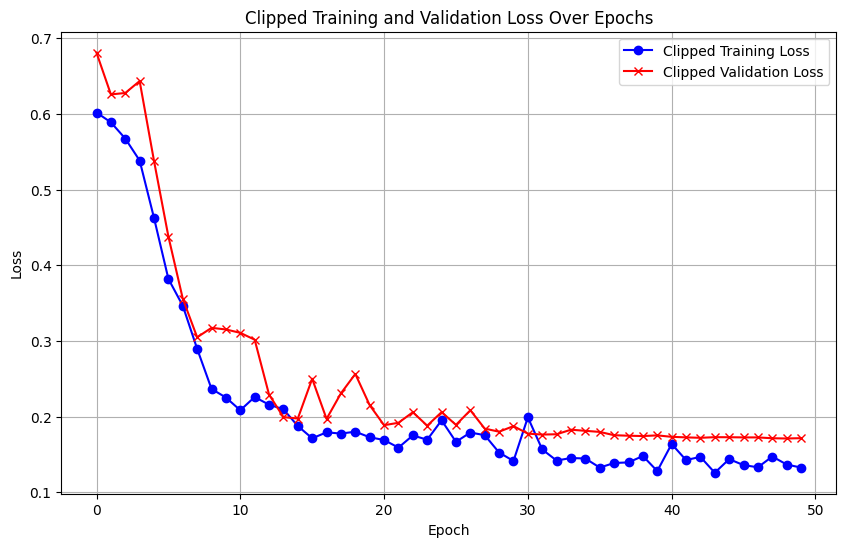

In [30]:
import matplotlib.pyplot as plt

train_losses = trainer_result['train_loss']
val_losses = trainer_result['loss']  # Assuming 'loss' contains the validation losses

max_loss = 1  # Set a threshold for maximum loss to visualize

clipped_train_losses = [min(loss, max_loss) for loss in train_losses]
clipped_val_losses = [min(loss, max_loss) for loss in val_losses]

plt.figure(figsize=(10, 6))
plt.plot(clipped_train_losses, label='Clipped Training Loss', color='blue', marker='o')
plt.plot(clipped_val_losses, label='Clipped Validation Loss', color='red', marker='x')
plt.title('Clipped Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

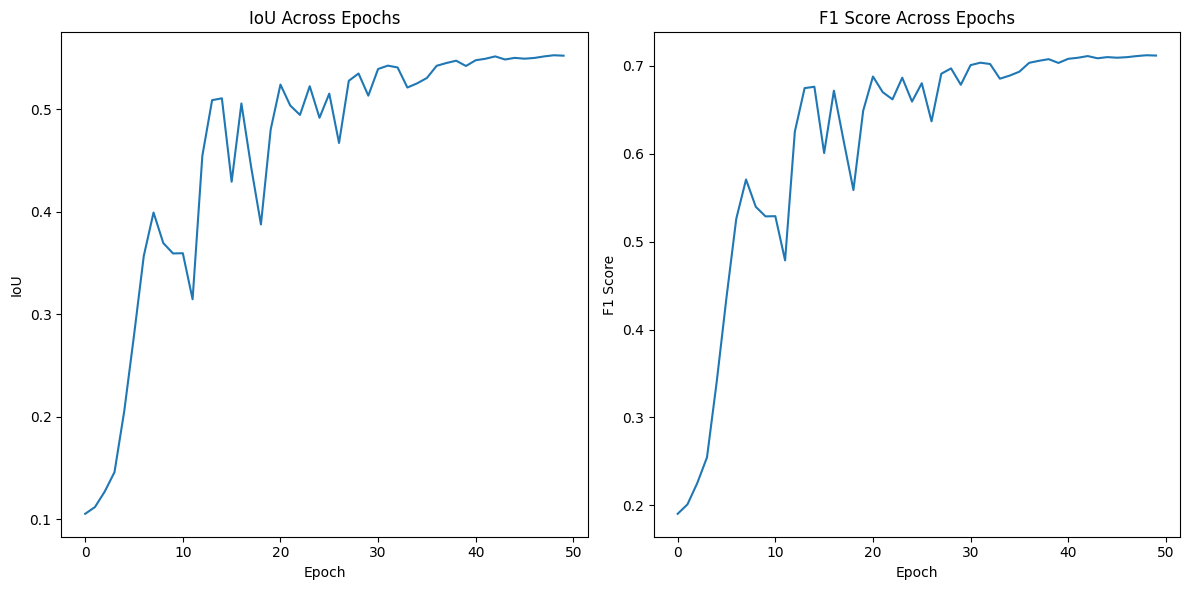

In [38]:
# Initialize lists to store IoU and F1-scores
ious = []
f1_scores = []

# Extract IoU and F1-score from each OrderedDict
for entry in trainer.val_results:
    ious.append(entry['iou'][1])
    f1_scores.append(entry['f1_score'][1])

# Convert lists to arrays for easier handling
ious = np.array(ious)
f1_scores = np.array(f1_scores)

# Plotting
plt.figure(figsize=(12, 6))

# Plot IoU
plt.subplot(1, 2, 1)
plt.plot(ious)  # Assuming you want the mean IoU of each epoch
plt.title('IoU Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')

# Plot F1-score
plt.subplot(1, 2, 2)
plt.plot(f1_scores)  # Assuming you want the mean F1-score of each epoch
plt.title('F1 Score Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

## ⭐ Evaluate

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

from torchvision.utils import save_image
from dataset import reconstruct_patched

def simple_micrograph_preprocessing(micrograph):
  micrograph_copy = micrograph.copy()
  micrograph_copy = (micrograph_copy-micrograph.mean()+2.5*micrograph.std())/5/micrograph.std()
  micrograph_copy[micrograph_copy<0]=0
  micrograph_copy[micrograph_copy>1]=1
  return micrograph_copy

!mkdir {RESULT_DIR}/Each_ckpt

In [41]:
# Check the last five best epochs
checkpoint_paths = [path for path in os.listdir(RESULT_DIR) if '.pt' in path]
for checkpoint_path in checkpoint_paths[-5:]:
  state_dict_path = f"{RESULT_DIR}/{checkpoint_path}"
  state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))
  model.load_state_dict(state_dict, strict=False)
  model.eval()
  print("\nLoad model at: ", state_dict_path)
  #trainer = CryoEMTrainerWithScheduler(model, train_dataset, criterion, optimizer, device,
  #              num_classes=NUM_CLASSES,
  #              lr_scheduler=scheduler, patience=ES_PATIENCE)
  #result = trainer.evaluate(test_loader)
  model.to(DEVICE)
  model.eval()
  mini_batch_size = 9  # Number of patches to process at once
  with torch.no_grad():
    idx, (test_image, _, grid, _) = next(enumerate(test_dataset))
    inputs = test_image.to(DEVICE)
    num_batches = (inputs.size(0) + mini_batch_size - 1) // mini_batch_size
    patched_outputs = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * mini_batch_size
        end_idx = min(start_idx + mini_batch_size, inputs.size(0))
        patch_input = inputs[start_idx:end_idx].to(DEVICE)
        output = model(patch_input)['out']
        patched_outputs.append(output.cpu())  # Move to CPU to conserve GPU memory

        del patch_input
        torch.cuda.empty_cache()
    outputs = torch.cat(patched_outputs).to(DEVICE)  # Move to CPU to conserve GPU memory
    del patched_outputs
    torch.cuda.empty_cache()
    preds = outputs.argmax(dim=1).unsqueeze(1).cpu().detach()  # Now preds will have shape [81, 1, 512, 512]

    ## Plotting
    micrograph = np.load(f"{IMAGE_DIR}/val/{val_filenames[idx][:-4]}.npy")
    label_path = f"{LABEL_DIR}/{val_filenames[idx][:-4]}.png"


    micrograph_copy = simple_micrograph_preprocessing(micrograph)
    #crop_amount = 128  # Amount cropped from each side of the label image
    mic_width, mic_height = micrograph_copy.shape[1], micrograph_copy.shape[0]

    # Calculate starting and ending indices for cropping the micrograph
    #start_x = int((mic_width - 3840) / 2)
    #end_x = start_x + 3840
    #start_y = int((mic_height - 3840) / 2)
    #end_y = start_y + 3840

    # Crop the micrograph
    cropped_micrograph = micrograph_copy
    pred_image = reconstruct_patched(preds, grid).float()

    _,ax = plt.subplots(figsize=(12, 12))
    ax.imshow(cropped_micrograph, cmap='gray')
    ax.imshow(pred_image.squeeze(), cmap='inferno', alpha=0.4)
    plt.show()
    ##

    filename = f"{os.path.splitext(checkpoint_path)[0]}.png"
    pred_path = os.path.join(RESULT_DIR, "Each_ckpt", filename)
    save_image(pred_image, pred_path)

Output hidden; open in https://colab.research.google.com to view.

### ✅ Testing

In [42]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [43]:
test_dir = os.path.join(IMAGE_DIR, 'test')
test_filenames = np.loadtxt(f"{IMAGE_DIR}/test_filenames.txt", dtype=str)
np.random.seed(24)
selected_filenames = np.random.choice(test_filenames, size=6, replace=False)
print(selected_filenames)
test_dataset = MicrographDatasetEvery(image_dir=test_dir, label_dir=LABEL_DIR, filenames=selected_filenames, crop_size=CROP_SIZE)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False, pin_memory=True)

['HCN1apo_1044_2xaligned.mrc' 'HCN1apo_0612_2xaligned.mrc'
 'HCN1apo_0437_2xaligned.mrc' 'HCN1apo_1007_2xaligned.mrc'
 'HCN1apo_0494_2xaligned.mrc' 'HCN1apo_0052_2xaligned.mrc']


In [44]:
evaluator = CryoEMEvaluator(
    model=model, device=DEVICE, metrics=['AP','iou'],
    num_classes=NUM_CLASSES)
print("ConvCRF validation result:")
result = evaluator.evaluate(loader=val_loader)
print("ConvCRF test result:")
result = evaluator.evaluate(loader=test_loader)

ConvCRF validation result:
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
Iou by Class: [0.92442095 0.5529319 ]
Precision by Class: [0.97562736 0.6404149 ]
Recall by Class: [0.9462738 0.8018903]
Accuracy by Class: [0.93088174 0.93088174]
F1_score by Class: [0.9607264 0.7121135]
ConvCRF test result:
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
Iou by Class: [0.9233062 0.5728088]
Precision by Class: [0.9668851  0.69527376]
Recall by Class: [0.9534567 0.7648179]
Accuracy by Class: [0.9304577 0.9304577]
F1_score by Class: [0.960124   0.72838956]
